# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.619345,True,5.370257
1,-0.523912,False,-0.064443
2,1.120075,True,5.100066
3,-0.204319,False,0.832837
4,0.567008,True,5.308252
...,...,...,...
995,2.675270,True,6.344446
996,-0.296710,False,0.918979
997,-0.978745,False,0.549463
998,1.102167,True,7.399635


<Axes: xlabel='v0'>

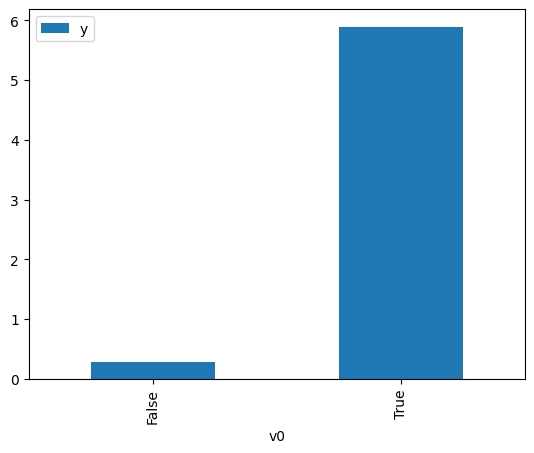

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

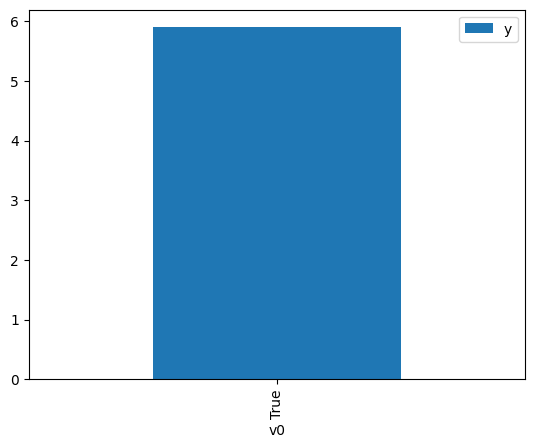

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.217250,False,-2.421533,0.907937,1.101398
1,1.529014,False,1.573238,0.043180,23.158978
2,0.146420,False,0.174800,0.404630,2.471396
3,-0.699930,False,0.012482,0.781418,1.279724
4,-1.006241,False,-1.301921,0.867012,1.153386
...,...,...,...,...,...
995,0.556357,False,1.330355,0.233201,4.288150
996,1.195496,False,0.261648,0.079876,12.519372
997,-0.029290,False,-0.612274,0.489615,2.042422
998,0.259649,False,0.601349,0.352443,2.837335


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.005422,True,5.644082,0.982583,1.017726
1,1.345647,True,7.151836,0.939264,1.064663
2,1.221417,True,6.062322,0.923782,1.082507
3,2.519772,True,8.882521,0.993579,1.006463
4,0.960653,True,6.012738,0.879040,1.137604
...,...,...,...,...,...
995,1.283447,True,6.546651,0.931919,1.073054
996,0.026533,True,5.030140,0.537690,1.859808
997,-1.472100,True,2.916581,0.057943,17.258287
998,0.286407,True,6.243102,0.659441,1.516437


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          1.563e+04
Date:                Wed, 20 Nov 2024   Prob (F-statistic):                        0.00
Time:                        16:22:45   Log-Likelihood:                         -1390.6
No. Observations:                1000   AIC:                                      2785.
Df Residuals:                     998   BIC:                                      2795.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8712      0.036     23.876      0.000       0.800       0.943
x2             5.1237      0.057     90.324      0.000       5.012       5.235
==============================================================================
Omnibus:                        3.130   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                3.032
Skew:                          -0.133   Prob(JB):                        0.220
Kurtosis:                       3.047   Cond. No.                         3.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""